# Generating Masks and Presence Predictions

### Imports

In [14]:
!pip install tensorflow

In [1]:
import os
import numpy             as np
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

plt.rcParams['figure.figsize']  = (16,8)

from tensorflow.keras.models import load_model
from osgeo                   import gdal
from PIL                     import Image
from math                    import ceil
from typing                  import Tuple

In [2]:
def get_image_array(
    image_path: str
) -> np.ndarray:

    """
    Load a interferogram .tif from storage into an array.

    Parameters:
    -----------
    image_path : str
        The path to the interferogram .tif to be opened.

    Returns:
    --------
    arr : np.ndarray
        The interferogram array.
    """

    from osgeo import gdal

    dataset = gdal.Open(image_path, gdal.GA_ReadOnly)
    band = dataset.GetRasterBand(1)
    arr = band.ReadAsArray()

    return arr, dataset


def pad(
    arr:            np.ndarray,
    tile_shape:     Tuple[int, int],
    value:          float = 0.0,
    extra_padding:  int   = 0,
    even_pad:       bool  = False,
) -> np.ndarray:

    """
    Pad an array with a given value so that it can be tiled.

    Parameters:
    -----------
    arr : np.ndarray
        The array that should be padded.
    tile_shape : tuple(int, int)
        A tuple representing the shape of the tiles (rows, columns) to pad for.
    value : float, Optional
        The value that should fill the padded area.
    extra_pad : int, Optional
        An extra amount of padding to add to each dimension.
    even_padding : bool, Optional
        If True, the array will be padded symmetrically; else, it will be padded
        on the end of each dimension.

    Returns:
    --------
    arr_padded : np.ndarray
        The padded array.
    """

    y, x = len(arr[:, 0]), len(arr[0, :])
    x_padded = x + (tile_shape[0] - (x % tile_shape[0])) + extra_padding
    y_padded = y + (tile_shape[1] - (y % tile_shape[1])) + extra_padding
    arr_padded = np.full((y_padded, x_padded), value)
    if even_pad:
        start_row = ceil((y_padded - y) / 2)
        end_row = start_row + y
        start_col = ceil((x_padded - x) / 2)
        end_col = start_col + x
        arr_padded[start_row:end_row, start_col:end_col] = arr
    else:
        arr_padded[:y, :x] = arr
    return arr_padded


def tile(
    arr:        np.ndarray,
    tile_shape: Tuple[int, int],
    crop_size:  int   = 0,
    x_offset:   int   = 0,
    y_offset:   int   = 0,
    even_pad:   bool  = False,
    pad_value:  float = 0.0
) -> Tuple[np.ndarray, int, int]:

    """
    Tile a 2-dimensional array into an array of tiles of shape tile_shape.

    Parameters:
    -----------
    arr : np.ndarray
        The 2-dimensional array that should be tiled.
    tile_shape : tuple(int, int)
        The desired shape of the tiles: (row length, column length). This
        should match the input shape of the model.
    crop_size : int, Optional
        An extra amount of padding to maintain full array coverage when the model
        will crop the tiles later. This amount should be equal to the shape of the
        output tiles from the model.
    x_offset : int, Optional
        Offset the tiling process by this amount in the columns direction.
    y_offset : int, Optional
        Offset the tiling process by this amount in the row direction.
    even_pad : bool, Optional
        If True, the array will be padded symmetrically; else, it will be padded
        on the end of each dimension.
    pad_value : float, Optional
        The value to fill the padded areas of the array with.

    Returns:
    --------
    tiles : np.ndarray
        The array of tiles.
    num_rows : int
        The number of rows of tiles.
    num_cols : int
        The number of columns of tiles.
    """

    cropped = crop_size > 0 and crop_size != tile_shape[0]
    rows, cols = len(arr[:, 0]), len(arr[0, :])

    if(cols % tile_shape[1] != 0 or rows % tile_shape[0] != 0):
        
        if x_offset > 0 or y_offset > 0:
            arr_offset = np.zeros((rows + y_offset, cols + x_offset))
            arr_offset[0:rows, 0:cols] = arr
            arr = arr_offset
        
        arr = pad(
            arr,
            tile_shape,
            even_pad=even_pad,
            extra_padding=(crop_size if cropped else 0),
            value=pad_value
        )
        
        rows, cols = len(arr[:, 0]), len(arr[0, :])

    if not cropped:
        num_rows  = rows // tile_shape[0] - ceil(y_offset / tile_shape[0])
        num_cols  = cols // tile_shape[1] - ceil(x_offset / tile_shape[1])
    else:
        num_rows  = ceil((rows - tile_shape[0]) / crop_size)  # = (h-th)/ch
        num_cols  = ceil((cols - tile_shape[1]) / crop_size)  # = (w-tw)/cw

    num_tiles = num_rows * num_cols

    tiles = np.zeros((num_tiles, tile_shape[0], tile_shape[1]))

    t_row = 0
    for i in range(num_rows):
        row = i * (crop_size if cropped else tile_shape[0])
        for j in range(num_cols):
            col = j * (crop_size if cropped else tile_shape[1])
            row_start = row + y_offset
            col_start = col + x_offset
            row_end   = row + y_offset + tile_shape[0]
            col_end   = col + x_offset + tile_shape[1]
            tiles[t_row, :, :] = arr[row_start:row_end, col_start:col_end]
            t_row += 1

    return tiles, num_rows, num_cols


def tiles_to_image(
    arr:            np.ndarray,
    rows:           int,
    cols:           int,
    original_shape: Tuple[int, int]
) -> np.ndarray:

    """
    Stich an array of 2-dimensional tiles into a single 2-dimensional array.

    Parameters:
    -----------
    arr : np.ndarray(shape=(rows*cols, tile_size, tile_size))
        The array of tiles to be stiched together.
    rows : int
        The number of tiles that should go in the row direction.
    cols : int
        The number of tiles that should go in the column direction.
    original_shape : Tuple[int, int]
        The shape of the interferogram before any processing.
    cropped : bool
        Set to True if the model has cropping, else leave it as False.
    tiling_size : int
        If the model was cropped, set this to the original tile size, else
        leave this false.

    Returns:
    --------
    rebuilt_arr : np.ndarray(shape=(rows*tile_size, cols*tile_size))
        The stiched 2-dimensional array.
    """

    row_tile_size = len(arr[0, :, 0])
    col_tile_size = len(arr[0, 0, :])

    assert row_tile_size == col_tile_size

    tile_size = row_tile_size

    rebuilt_arr = np.zeros((rows * tile_size, cols * tile_size))
    for i in range(rows):
        row = i * tile_size
        for j in range(cols):
            col = j * tile_size
            rebuilt_arr[row:row + tile_size, col:col + tile_size] = arr[(i * cols) + j]

    (y, x) = original_shape

    x_padded = x + (tile_size - (x % tile_size))
    y_padded = y + (tile_size - (y % tile_size))

    start_row = ceil((y_padded - y) / 2)
    end_row = (start_row + y)
    start_col = ceil((x_padded - x) / 2)
    end_col = (start_col + x)

    rebuilt_arr = rebuilt_arr[start_row:end_row, start_col:end_col]

    return rebuilt_arr


def mask_with_model(
    mask_model,
    pres_model,
    arr_w:     np.ndarray,
    tile_size: int,
    crop_size: int   = 0
) -> np.ndarray:

    """
    Use a keras model prediction to mask events in a wrapped interferogram.

    Parameters:
    -----------
    model_path : str
        The path to the model to use for masking.
    pres_model_path : str
        The path to the model that predicts the presence of an event in a mask.
    arr_w : np.ndarray
        The wrapped interferogram array.
    tile_size : int
        The width and height of the tiles that the image will be broken into, this needs
        to match the input shape of the model.
    crop_size : int, Optional
        If the models output shape is different than the input shape, this value needs to be
        equal to the output shape of the masking model and input shape of the presence model.

    Returns:
    --------
    mask : np.ndarray(shape=(tile_size, tile_size) or (crop_size, crop_size))
        The array containing the event-mask array as predicted by the model.
    pres_mask : np.ndarray(shape=(tile_size, tile_size) or (crop_size, crop_size))
        An array containing tiles where the tile is all 1s if there is an event else 0s.
        If even a single tile has 1s that means an event has been identified.
    """

    tiled_arr_w, w_rows, w_cols = tile(
        arr_w,
        (tile_size, tile_size),
        x_offset  = 0,
        y_offset  = 0,
        even_pad  = True,
        crop_size = crop_size
    )

    zeros = tiled_arr_w == 0

    if crop_size == 0:
        crop_size = tile_size

    # tiled_arr_w += np.pi
    # tiled_arr_w /= (2*np.pi)
    # tiled_arr_w[zeros] = 0

    mask_tiles = mask_model.predict(tiled_arr_w, batch_size=1)

    mask_tiles[zeros] = 0

    rnd  = mask_tiles >= 0.5
    trnc = mask_tiles <  0.5
    mask_tiles[trnc]  = 0
    mask_tiles[rnd]   = 1

    pres_vals  = pres_model.predict(mask_tiles, batch_size=1)
    pres_tiles = np.zeros((w_rows*w_cols, tile_size, tile_size))

    index = 0
    for val in pres_vals:
        if val >= 0.75:
            pres_tiles[index] = 1
        index += 1

    mask_tiles = mask_tiles.reshape((w_rows*w_cols, tile_size, tile_size))

    mask = tiles_to_image(
        mask_tiles,
        w_rows,
        w_cols,
        arr_w.shape
    )

    mask[arr_w == 0] = 0

    pres_mask = tiles_to_image(
        pres_tiles,
        w_rows,
        w_cols,
        arr_w.shape
    )

    return mask, pres_mask, pres_vals

In [3]:
def plot_results(wrapped, mask, presence_mask):

    _, [axs_wrapped, axs_mask, axs_presence_mask] = plt.subplots(1, 3)

    axs_wrapped.set_title('Wrapped')
    axs_mask.set_title('Segmentation Mask')
    axs_presence_mask.set_title('Presence Mask')
    
    axs_wrapped.imshow(wrapped, origin='lower', cmap='jet')
    axs_mask.imshow(mask, origin='lower', cmap='jet')
    axs_presence_mask.imshow(presence_mask, origin='lower', cmap='jet')

### Initiallize Variables

In [5]:
tile_size = 512
crop_size = 512

mask_model_path = '../models/mask_model'
pres_model_path = '../models/pres_model'
image_path      = '../36B1.tif'
output_path     = '../36B1_mask.tif'

mask_model = load_model(mask_model_path)
pres_model = load_model(pres_model_path)

is_wrapped = True

if is_wrapped:
    wrapped, gdal_dataset = get_image_array(image_path)
else:
    unwrapped, gdal_dataset = get_image_array(image_path)
    wrapped      = np.angle(np.exp(1j * (unwrapped)))

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2080 SUPER, compute capability 7.5


### Inference on a Single Wrapped or Unwrapped Image

In [6]:
mask, presence_mask, presence_values = mask_with_model(
    mask_model = mask_model,
    pres_model = pres_model,
    arr_w      = wrapped,
    tile_size  = tile_size,
    crop_size  = crop_size
)

### Plot Results

Positive!


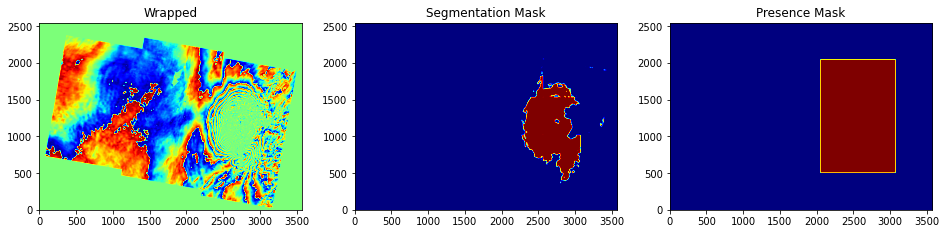

In [9]:
if np.max(presence_values) > 0.7:
    print("Positive!")
else:
    print("Negative!")

mask[wrapped == 0] = 0

plot_results(wrapped, mask, presence_mask)

### Save with Geo-Metadata

In [22]:
output_img = Image.fromarray(mask)
output_img.save(output_path)

out_dataset = gdal.Open(output_path, gdal.GA_Update)
out_dataset.SetProjection(gdal_dataset.GetProjection())
out_dataset.SetGeoTransform(gdal_dataset.GetGeoTransform())
out_dataset.FlushCache()